In [1]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader

from datetime import datetime
from pprint import pprint
from models import MarkowitzMinVarianceModel

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn') # style.use('ggplot') # style.use('fivethirtyeight')
%matplotlib inline

In [2]:
df_topix30 = pd.read_csv("../data/tse_topixcore30_20111031.csv")

stocks_topix30 = df_topix30['コード'].values
symbols =  [str(s)+'.T' for s in stocks_topix30]

st = '2000/10/31' 
ed = '2020/10/31'

dfs = []
for symbol in symbols:
    df = pandas_datareader.data.DataReader(symbol, 'yahoo', st, ed) # daily
    df = df.resample('M').mean() # daily -> monthly
    df = df.sort_values(by='Date', ascending=True)
    df = df.fillna(method='ffill') # 1つ前の行の値で埋める
    df = df[['Close']].rename(columns={'Close': symbol})
    dfs.append(df)

df = pd.concat(dfs, axis=1)
df.head()

2914.T       3382.T       4063.T       4502.T       4503.T  \
Date                                                                         
2000-10-31  750.000000  1969.000000  4480.000000  7190.000000   988.000000   
2000-11-30  730.454545  1935.318182  4690.000000  6986.818182  1025.363636   
2000-12-31  791.952381  1837.809524  4690.000000  6712.380952   994.857143   
2001-01-31  826.913043  1879.826087  4293.913043  6439.130435   900.347826   
2001-02-28  828.850000  1905.210526  4344.736842  5922.105263   869.684211   

                 5401.T      6301.T  6502.T  6752.T       6758.T  ...  \
Date                                                              ...   
2000-10-31  1770.000000  484.000000     NaN     NaN  8720.000000  ...   
2000-11-30  1830.454545  523.090909     NaN     NaN  8627.727273  ...   
2000-12-31  1975.714286  527.476190     NaN     NaN  8331.428571  ...   
2001-01-31  1910.000000  509.000000     NaN     NaN  8586.086957  ...   
2001-02-28  1997.894737  537.947368     NaN     NaN  8348.421053  ...   

                 8604.T  8766.T       8802.T  9021.T       9432.T      9433.T  \
Date                                                                            
2000-10-31  2315.000000     NaN  1160.000000     NaN  2482.500000  853.333008   
2000-11-30  2484.545455     NaN  1204.636364     NaN  2584.772727  874.166637   
2000-12-31  2269.047619     NaN  1239.619048     NaN  2258.333333  986.746379   
2001-01-31  2151.652174     NaN  1124.478261     NaN  2400.652174  970.579436   
2001-02-28  2267.368421     NaN  1090.842105     NaN  2056.125000  876.315789   

                 9437.T       9501.T       9503.T       9984.T  
Date                                                            
2000-10-31  5380.000000  2650.000000  1787.000000  1091.670044  
2000-11-30  5798.095238  2642.272727  1779.454545  1256.666964  
2000-12-31  5078.095238  2685.952381  1879.571429   812.698571  
2001-01-31  4400.000000  2698.913043  1874.304348   911.774910  
2001-02-28  4212.631579  2643.947368  1898.578947   960.701522  

[5 rows x 30 columns]

In [3]:
for col in df.columns:
    st_idx = df[col].first_valid_index()
    ed_idx = df[col].last_valid_index()
    
    if df[col].isnull().any():
        # 新規上場
        if st_idx != df.index[0]:
            df[col] = df[col].fillna(df[col][st_idx])

        # 上場廃止
        if df.index[-1] != ed_idx:
            df[col] = df[col].fillna(df[col][ed_idx])

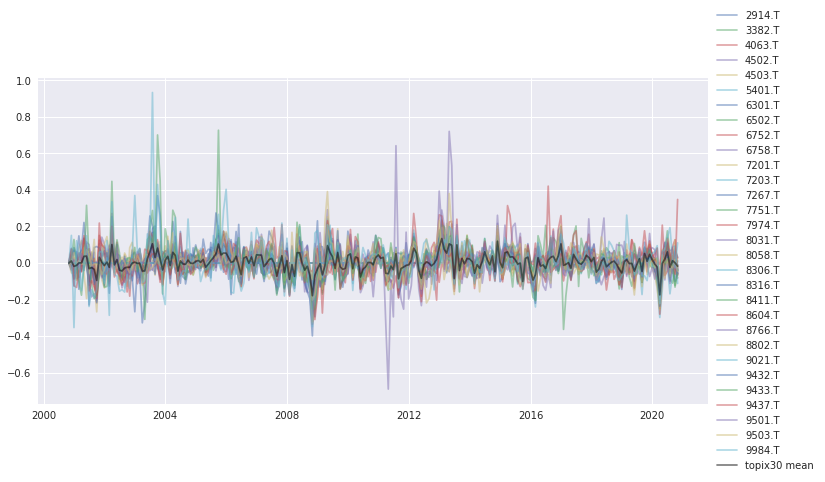

In [4]:
df_retchg = df.pct_change()
df_retchg[:1] = 0.0 # set 0.0 to the first record

plt.figure(figsize=(12, 6))
for idx, col in enumerate(df.columns):
    plt.plot(df_retchg.index, df_retchg[col], label=col, alpha=0.5)
plt.plot(df_retchg.index, df_retchg.mean(axis='columns'), label="topix30 mean", color="black", alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

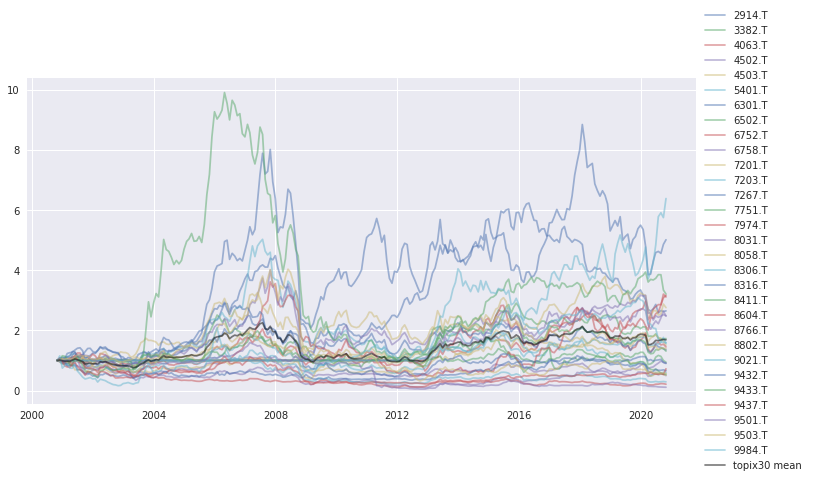

In [5]:
df_retcum = (1.0 + df_retchg).cumprod()
df_retcum[:1] = 1.0 # set 1.0 to the first record

plt.figure(figsize=(12, 6))
for idx, col in enumerate(df.columns):
    plt.plot(df_retcum.index, df_retcum[col], label=col, alpha=0.5)
plt.plot(df_retcum.index, df_retcum.mean(axis='columns'), label="topix30 mean", color="black", alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

# backtesting

In [6]:
# Risk-free rate (10Year-JGB, monthly interest)
r_f = (1 + 0.0001) ** (1/12) - 1.0
r_e = r_f # (1 + 0.01) ** (1/12) - 1.0

Portfolio Performance
Returns per month
  sharpe ratio     : 0.13112103
  mean of returns  : 0.00377877
  std of returns   : 0.02875541
    risk-free rate : 0.00000833
    capgain ratio  : 0.99231380
Returns per year
  sharpe ratio     : 0.45421654
  mean of returns  : 0.04534526
  std of returns   : 0.09961166


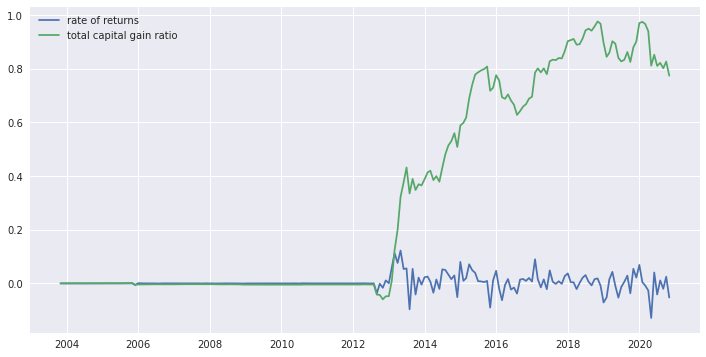

In [7]:
params = {
    "window_size": 36,
    "rebalance_freq": 1,
    "r_e": r_e,
    "r_f": r_f
}

# mmvp
mmvp = MarkowitzMinVarianceModel(df, **params)
df_bt = mmvp.backtest()
mmvp.evaluate_backtest(logging=True)
mmvp.plot_returns()

Portfolio Performance
Returns per month
  sharpe ratio     : 0.13611974
  mean of returns  : 0.00423639
  std of returns   : 0.03106133
    risk-free rate : 0.00000833
    capgain ratio  : 0.97100581
Returns per year
  sharpe ratio     : 0.47153259
  mean of returns  : 0.05083672
  std of returns   : 0.10759960


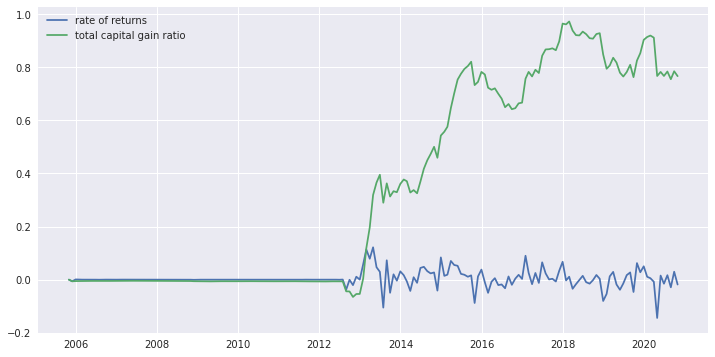

In [8]:
params = {
    "window_size": 60,
    "rebalance_freq": 1,
    "r_e": r_e,
    "r_f": r_f
}

# mmvp
mmvp = MarkowitzMinVarianceModel(df, **params)
df_bt = mmvp.backtest()
mmvp.evaluate_backtest(logging=True)
mmvp.plot_returns()

Portfolio Performance
Returns per month
  sharpe ratio     : 0.14063489
  mean of returns  : 0.00453204
  std of returns   : 0.03216632
    risk-free rate : 0.00000833
    capgain ratio  : 0.96909453
Returns per year
  sharpe ratio     : 0.48717351
  mean of returns  : 0.05438447
  std of returns   : 0.11142739


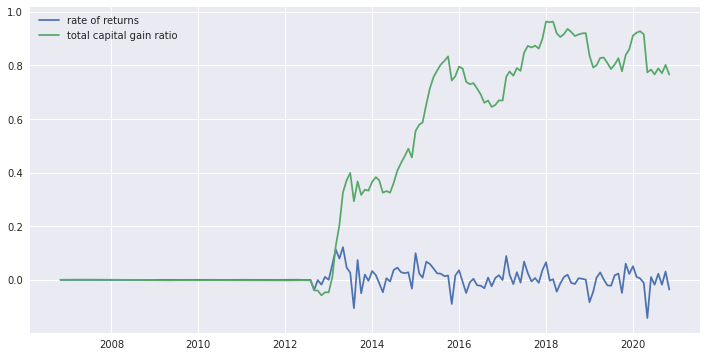

In [9]:
params = {
    "window_size": 72,
    "rebalance_freq": 1,
    "r_e": r_e,
    "r_f": r_f
}

# mmvp
mmvp = MarkowitzMinVarianceModel(df, **params)
df_bt = mmvp.backtest()
mmvp.evaluate_backtest(logging=True)
mmvp.plot_returns()

Portfolio Performance
Returns per month
  sharpe ratio     : 0.19504268
  mean of returns  : 0.01337199
  std of returns   : 0.06851657
    risk-free rate : 0.00000833
    capgain ratio  : 0.88989955
Returns per year
  sharpe ratio     : 0.67564766
  mean of returns  : 0.16046386
  std of returns   : 0.23734835


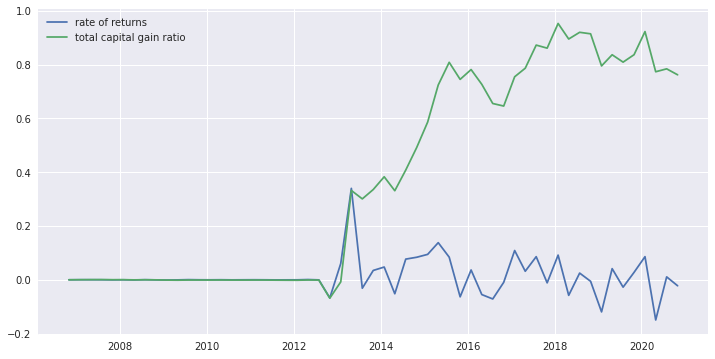

In [10]:
params = {
    "window_size": 72,
    "rebalance_freq": 3,
    "r_e": r_e,
    "r_f": r_f
}

# mmvp
mmvp = MarkowitzMinVarianceModel(df, **params)
df_bt = mmvp.backtest()
mmvp.evaluate_backtest(logging=True)
mmvp.plot_returns()

Portfolio Performance
Returns per month
  sharpe ratio     : 0.11889813
  mean of returns  : 0.00456860
  std of returns   : 0.03835439
    risk-free rate : 0.00000833
    capgain ratio  : 0.58963429
Returns per year
  sharpe ratio     : 0.41187518
  mean of returns  : 0.05482318
  std of returns   : 0.13286350


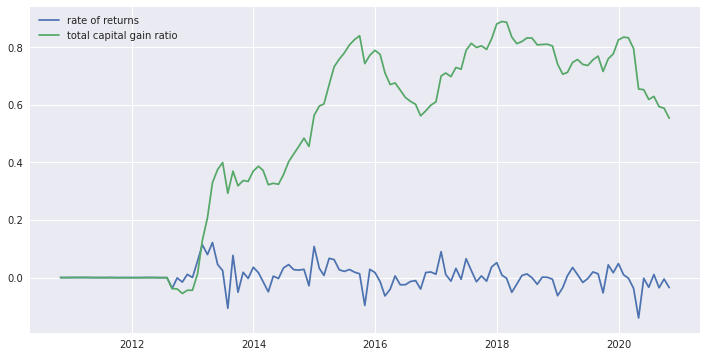

In [11]:
params = {
    "window_size": 120,
    "rebalance_freq": 1,
    "r_e": r_e,
    "r_f": r_f
}

# mmvp
mmvp = MarkowitzMinVarianceModel(df, **params)
df_bt = mmvp.backtest()
mmvp.evaluate_backtest(logging=True)
mmvp.plot_returns()